In [2]:
# Setup

import os, sys
sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from src.model import get_model
from src.gradcam import GradCAM
from torchvision import transforms



In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device


device(type='mps')

In [4]:
model = get_model(pretrained=False).to(device)
model.load_state_dict(torch.load("../results/resnet50_pneumonia.pt", map_location=device))
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# Prepare an Image

img_path = "../data/images/00000041_006.png"  # change this to any image
image = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

input_tensor = transform(image).unsqueeze(0).to(device)


In [6]:


target_layer = model.layer4[-1]   # last conv layer of ResNet
gradcam = GradCAM(model, target_layer)



In [7]:
# Generate Grad Cam

cam = gradcam.generate(input_tensor)

cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
cam_resized = cv2.resize(cam, (224,224))


Text(0.5, 1.0, 'Grad-CAM Overlay')

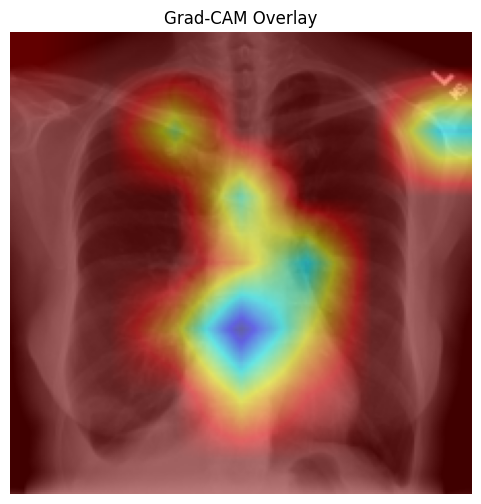

In [8]:

# Create Overlay
img_np = np.array(image.resize((224,224)))

heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
overlay = 0.5 * heatmap + 0.5 * img_np

plt.figure(figsize=(6,6))
plt.imshow(overlay.astype(np.uint8))
plt.axis("off")
plt.title("Grad-CAM Overlay")


In [10]:
# Get prediction on validation set

import pandas as pd
import torch
from tqdm import tqdm

model.eval()

val_df = pd.read_csv("../data/processed/val_small.csv")  # or val.csv
image_dir = "../data/images"

results = []

with torch.no_grad():
    for idx in tqdm(range(len(val_df))):
        row = val_df.iloc[idx]
        img_path = f"{image_dir}/{row['Image Index']}"
        image = Image.open(img_path).convert("RGB")

        input_tensor = transform(image).unsqueeze(0).to(device)
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()
        pred = 1 if prob > 0.5 else 0
        label = row["Pneumonia"]

        results.append({
            "image": row["Image Index"],
            "label": label,
            "pred": pred,
            "prob": prob
        })

results_df = pd.DataFrame(results)
results_df.head()


100%|███████████████████████████████████████| 5000/5000 [09:36<00:00,  8.67it/s]


,image,label,pred,prob
0,00005313_000.png,0,0,0.457369
1,00013260_004.png,0,0,0.437570
2,00022611_010.png,0,0,0.462680
3,00029813_017.png,0,0,0.446417
4,00021610_027.png,0,0,0.460703


In [11]:
# Split into true positive, true negative and false positive

tp_df = results_df[(results_df.label == 1) & (results_df.pred == 1)]
fn_df = results_df[(results_df.label == 1) & (results_df.pred == 0)]
tn_df = results_df[(results_df.label == 0) & (results_df.pred == 0)]

print("TP:", len(tp_df))
print("FN:", len(fn_df))
print("TN:", len(tn_df))


TP: 5
FN: 62
TN: 4497


In [12]:
# Pick one example from each case
tp_img = tp_df.iloc[0]["image"]
fn_img = fn_df.iloc[0]["image"]
tn_img = tn_df.iloc[0]["image"]

tp_img, fn_img, tn_img


('00029763_004.png', '00003585_000.png', '00005313_000.png')

In [13]:
# Function to run Grad-CAM on one image
def run_gradcam_on_image(img_name, title):
    img_path = f"{image_dir}/{img_name}"
    image = Image.open(img_path).convert("RGB")

    input_tensor = transform(image).unsqueeze(0).to(device)
    cam = gradcam.generate(input_tensor)

    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    cam_resized = cv2.resize(cam, (224,224))

    img_np = np.array(image.resize((224,224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    overlay = 0.5 * heatmap + 0.5 * img_np

    plt.figure(figsize=(5,5))
    plt.imshow(overlay.astype(np.uint8))
    plt.title(title)
    plt.axis("off")


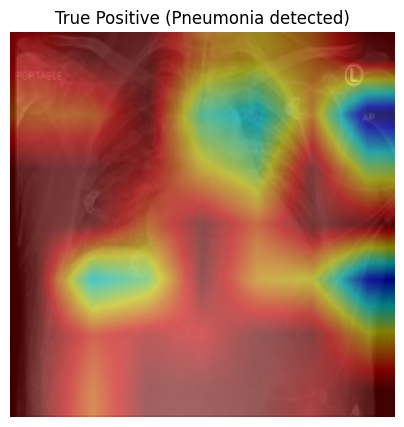

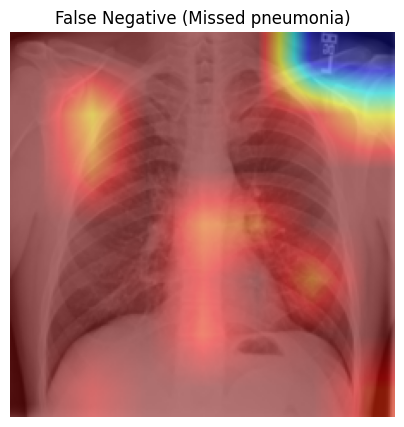

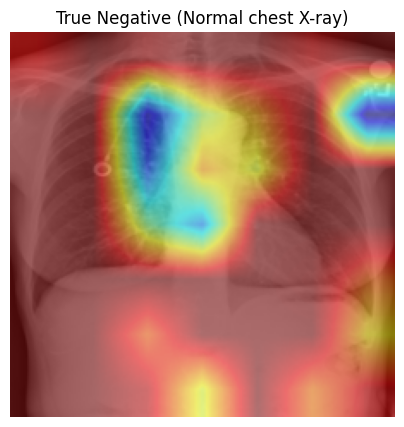

In [14]:
# Generate the three cases
run_gradcam_on_image(tp_img, "True Positive (Pneumonia detected)")
run_gradcam_on_image(fn_img, "False Negative (Missed pneumonia)")
run_gradcam_on_image(tn_img, "True Negative (Normal chest X-ray)")



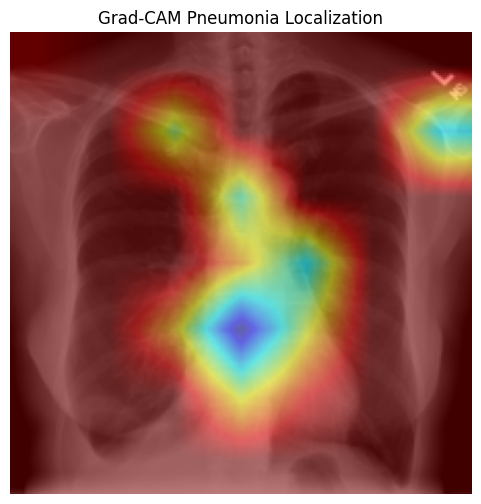

Saved to: ../results/gradcam/sample_gradcam.png


In [15]:
# Save grad-cam images 
import os
import matplotlib.pyplot as plt

os.makedirs("../results/gradcam", exist_ok=True)

plt.figure(figsize=(6,6))
plt.imshow(overlay.astype(np.uint8))
plt.axis("off")
plt.title("Grad-CAM Pneumonia Localization")

save_path = "../results/gradcam/sample_gradcam.png"
plt.savefig(save_path, bbox_inches="tight")
plt.show()

print("Saved to:", save_path)
